# Analyze, identify patterns, and explore the data

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
os.getcwd()

'C:\\Users\\IBM_ADMIN\\Documents\\GitHub\\Portfolio\\road_safety_project\\code'

In [3]:
os.chdir("../data/initial_download/")

In [4]:
acc = pd.read_csv("Accidents_2015.csv", dtype={'Accident_Index': str})
cas = pd.read_csv("Casualties_2015.csv", dtype={'Accident_Index': str})
veh = pd.read_csv("Vehicles_2015.csv", dtype={'Accident_Index': str})

In [5]:
acc.reset_index().head()

,index,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
0,0,201501BS70001,525130.0,180050.0,-0.198465,51.505538,1,3,1,1,...,0,0,4,1,1,0,0,1,1,E01002825
1,1,201501BS70002,526530.0,178560.0,-0.178838,51.491836,1,3,1,1,...,0,0,1,1,1,0,0,1,1,E01002820
2,2,201501BS70004,524610.0,181080.0,-0.205590,51.514910,1,3,1,1,...,0,1,4,2,2,0,0,1,1,E01002833
3,3,201501BS70005,524420.0,181080.0,-0.208327,51.514952,1,3,1,1,...,0,0,1,1,2,0,0,1,2,E01002874
4,4,201501BS70008,524630.0,179040.0,-0.206022,51.496572,1,2,2,1,...,0,5,1,2,2,0,0,1,2,E01002814


In [6]:
df = pd.read_csv('../../data_transformed/20170301_merged_dataset.csv',
                 dtype={'Accident_Index':str})

C:\Users\IBM_ADMIN\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.columns

Index([u'Accident_Index', u'Location_Easting_OSGR', u'Location_Northing_OSGR',
       u'Longitude', u'Latitude', u'Police_Force', u'Accident_Severity',
       u'Number_of_Vehicles', u'Number_of_Casualties', u'Date', u'Day_of_Week',
       u'Time', u'Local_Authority_(District)', u'Local_Authority_(Highway)',
       u'1st_Road_Class', u'1st_Road_Number', u'Road_Type', u'Speed_limit',
       u'Junction_Detail', u'Junction_Control', u'2nd_Road_Class',
       u'2nd_Road_Number', u'Pedestrian_Crossing-Human_Control',
       u'Pedestrian_Crossing-Physical_Facilities', u'Light_Conditions',
       u'Weather_Conditions', u'Road_Surface_Conditions',
       u'Special_Conditions_at_Site', u'Carriageway_Hazards',
       u'Urban_or_Rural_Area', u'Did_Police_Officer_Attend_Scene_of_Accident',
       u'LSOA_of_Accident_Location', u'Vehicle_Reference',
       u'Casualty_Reference', u'Casualty_Class', u'Sex_of_Casualty',
       u'Age_of_Casualty', u'Age_Band_of_Casualty', u'Casualty_Severity',
       u'P

# Set a Target

Let's start with the first problem posed by JStone Insurance - enhanced risk pricing. We want to identify the most serious accidents.

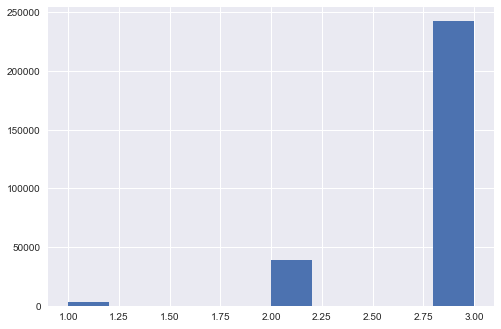

In [8]:
df['Accident_Severity'].hist()
# 1 - Fatal, 2 - Serious, 3 - Slight

Clearly, most accidents are 'slight'. Where the accident severity currently has three categories, we want a target variable that is either 1 or 0. Therefore, for our initial purposes, we shall classify accidents as a worth identifying as those that are either fatal or serious (bad accidents), with the slight accidents being not worth identifying (not bad accidents).

In [9]:
df['SeriousFatal'] = np.where(df['Accident_Severity'] < 3, 1, 0)
acc['SeriousFatal'] = np.where(acc['Accident_Severity'] < 3, 1, 0)
acc[['Accident_Severity', 'SeriousFatal']].head()

,Accident_Severity,SeriousFatal
0,3,0
1,3,0
2,3,0
3,3,0
4,2,1


Create an 'Is in Greater London' boolean field for the merged data and the accident dataset.

In [10]:
df_lon = df[df['IsGreaterLondon']==1]
df_lon.shape

(56157, 70)

In [11]:
acc['IsGreaterLondon'] = np.where( (acc['Latitude']>51.280482) & (acc['Latitude']<51.719346) & (acc['Longitude']<0.266473) & (acc['Longitude']>-0.539510), 1, 0)
acc_lon = acc[acc['IsGreaterLondon']==1]

# Analyse the dataset as a whole

In [12]:
acc['SeriousFatal'].mean()

0.15460958473753356

15% of the accidents are 'bad' accidents. Our job now will be to identify what these accidents have in common.

In [13]:
def univariate_proportion(data, field_name):
    ###Produce a table splitting by the chosen field giving the proportion of accidents that were serious or fatal.
    grpby = data[['Accident_Index', 'SeriousFatal', field_name]].groupby(field_name).aggregate({'Accident_Index':pd.Series.nunique, 'SeriousFatal':np.sum})
    grpby['Proportion_Serious_or_Fatal'] = grpby['SeriousFatal'] / grpby['Accident_Index']
    return grpby

In [14]:
def produce_proportion_chart(df, field_name):
    df.reset_index(inplace=True)
    sns.barplot(data=df, x=field_name, y='Proportion_Serious_or_Fatal')

In [15]:
# Create crosstables for each of the categorical variables with the target variable.
# Have a look for which values of these categorical variables has a higher proportion of bad accidents.
# Any variable & value combination that produces more than 15% bad accidents should be investigated.

categorical_variables = [u'Police_Force',
       'Day_of_Week', 'Local_Authority_(Highway)', '1st_Road_Class',
       'Road_Type', 'Speed_limit', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'Casualty_Class', 'Sex_of_Casualty',
       'Age_Band_of_Casualty', u'Casualty_Severity',
       'Casualty_Type', 'Vehicle_Type',
       'Journey_Purpose_of_Driver', 'Sex_of_Driver', 
       'Age_Band_of_Driver', u'Propulsion_Code']

# Create a dictionary for the variable & value, and the proportion of bad accidents.
prop_dict={}
for var in categorical_variables:
    
    ct = pd.crosstab(index=df['SeriousFatal'], columns=df[var], normalize='columns')
    
    for x in df[var].unique():
        prop = ct.iloc[1][x]
        
        key = str(var) + " = " + str(x)
        prop_dict[key] = prop
        
#Remove any null proportions
for keyvalue in prop_dict.items():
    if type(keyvalue[1]) is not np.float64:
        del prop_dict[keyvalue[0]]

#Sort based on the proportion        
sorted(prop_dict.items(), key=lambda x:x[1], reverse=True)

[('Casualty_Severity = 2.0', 1.0),
 ('Casualty_Severity = 1.0', 1.0),
 ('Propulsion_Code = 4', 1.0),
 ('Vehicle_Type = 23', 0.55555555555555558),
 ('Casualty_Type = 23.0', 0.55555555555555558),
 ('Local_Authority_(Highway) = S12000020', 0.42553191489361702),
 ('Local_Authority_(Highway) = S12000034', 0.41590214067278286),
 ('Casualty_Type = 5.0', 0.3894599681482554),
 ('Vehicle_Type = 5', 0.38253498385360601),
 ('Police_Force = 92', 0.37988362427265171),
 ('Casualty_Type = 17.0', 0.36046511627906974),
 ('Casualty_Type = 97.0', 0.33333333333333331),
 ('Local_Authority_(Highway) = S12000033', 0.30637254901960786),
 ('Casualty_Type = 4.0', 0.30282375851996107),
 ('Casualty_Type = 90.0', 0.29999999999999999),
 ('Vehicle_Type = 4', 0.2988606485539001),
 ('Casualty_Type = 21.0', 0.29797979797979796),
 ('Local_Authority_(Highway) = E06000017', 0.29608938547486036),
 ('Vehicle_Type = 97', 0.29537366548042704),
 ('Age_Band_of_Casualty = 11.0', 0.29076125052572549),
 ('Local_Authority_(Highway) 

Ignoring the original casualty severity variable, propulsion code and vehicle type are worth investigating more.

## Vehicle Investigation

In [16]:
pd.crosstab(index=df['SeriousFatal'], columns=df['Vehicle_Type'], normalize='columns')

Vehicle_Type,-1,1,2,3,4,5,8,9,10,11,...,17,18,19,20,21,22,23,90,97,98
SeriousFatal,,,,,,,,,,,,,,,,,,,,,
0,0.827586,0.815767,0.823993,0.784272,0.701139,0.617465,0.887143,0.86782,0.776712,0.844914,...,0.724951,0.888889,0.857407,0.830317,0.786337,0.752252,0.444444,0.792883,0.704626,0.858044
1,0.172414,0.184233,0.176007,0.215728,0.298861,0.382535,0.112857,0.13218,0.223288,0.155086,...,0.275049,0.111111,0.142593,0.169683,0.213663,0.247748,0.555556,0.207117,0.295374,0.141956


|**code** |	**label**
|----------------------------------|
|1	      |Pedal cycle
|2	      |Motorcycle 50cc and under
|3	      |Motorcycle 125cc and under
|4	      |Motorcycle over 125cc and up to 500cc
|5	      |Motorcycle over 500cc
|8	      |Taxi/Private hire car
|9	      |Car
|10	      |Minibus (8 - 16 passenger seats)
|11	      |Bus or coach (17 or more pass seats)
|16	      |Ridden horse
|17	      |Agricultural vehicle
|18	      |Tram
|19	      |Van / Goods 3.5 tonnes mgw or under
|20	      |Goods over 3.5t. and under 7.5t
|21	      |Goods 7.5 tonnes mgw and over
|22	      |Mobility scooter
|23	      |Electric motorcycle
|90	      |Other vehicle
|97	      |Motorcycle - unknown cc
|98	      |Goods vehicle - unknown weight
|-1	      |Data missing or out of range


For a bit of clarity, some of the labels can be combined (motorcycles, rare, etc)

In [17]:
def group_vehicle_types(x):
    if x == 2 or x == 3 or x == 4 or x == 5 or x == 23 or x == 97:
        return 'Motorcycle'
    elif x == 19 or x == 20 or x == 21 or x == 98:
        return 'Van/HGV'
    elif x == 9:
        return 'Car'
    elif x == 1:
        return 'Pedal Cycle'
    elif x == 11:
        return 'Bus/Coach'
    elif x == 8:
        return 'Taxi/Private Hire'
    elif x == 90:
        return 'Other'
    elif x == 10:
        return 'Minibus'
    elif x == 16:
        return 'Ridden Horse'
    elif x == 17:
        return 'Agricultural Vehicle'
    elif x == 18:
        return 'Tram'
    elif x == 22:
        return 'Mobility Scooter'
    else:
        return str(x)

df['Vehicle_Type_Grouped'] = df['Vehicle_Type'].apply(group_vehicle_types)
df.head()

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type,Vehicle_IMD_Decile,IsGreaterLondon,SeriousFatal,Vehicle_Type_Grouped
0,201501BS70001,525130.0,180050.0,-0.198465,51.505538,1,3,1,1,12/01/2015,...,-1,2143,2,4,-1,-1,-1,1,0,Van/HGV
1,201501BS70002,526530.0,178560.0,-0.178838,51.491836,1,3,1,1,12/01/2015,...,-1,1600,1,3,-1,-1,-1,1,0,Car
2,201501BS70004,524610.0,181080.0,-0.205590,51.514910,1,3,1,1,12/01/2015,...,6,1686,2,10,-1,1,-1,1,0,Car
3,201501BS70005,524420.0,181080.0,-0.208327,51.514952,1,3,1,1,13/01/2015,...,-1,-1,-1,-1,-1,-1,-1,1,0,Car
4,201501BS70008,524630.0,179040.0,-0.206022,51.496572,1,2,2,1,09/01/2015,...,8,-1,-1,-1,-1,1,-1,1,1,Pedal Cycle


In [18]:
#per_acc = df[['Accident_Index', 'SeriousFatal', 'Vehicle_Type_Grouped']].groupby('Accident_Index').first().reset_index()
grpby_veh = df[['Accident_Index', 'SeriousFatal', 'Vehicle_Type_Grouped']].groupby('Vehicle_Type_Grouped').aggregate({'Accident_Index':pd.Series.count, 'SeriousFatal':np.sum}).reset_index()
grpby_veh['Proportion_Serious_or_Fatal'] = grpby_veh['SeriousFatal'] / grpby_veh['Accident_Index']
grpby_veh[grpby_veh['Accident_Index']>1000]

,Vehicle_Type_Grouped,SeriousFatal,Accident_Index,Proportion_Serious_or_Fatal
2,Bus/Coach,1078,6951,0.155086
3,Car,27227,205985,0.132180
6,Motorcycle,6067,21800,0.278303
7,Other,291,1405,0.207117
8,Pedal Cycle,3613,19611,0.184233
10,Taxi/Private Hire,711,6300,0.112857
12,Van/HGV,3500,21812,0.160462


In [19]:
grpby_veh['SeriousFatal'].sum()

42875

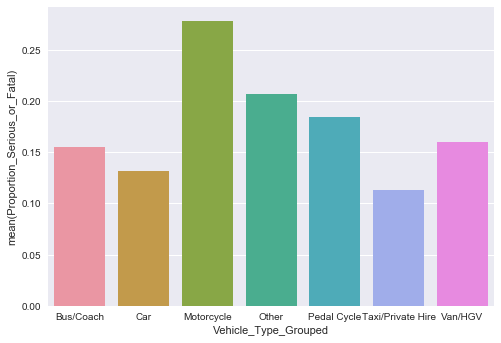

In [20]:
sns.barplot(data=grpby_veh[grpby_veh['Accident_Index']>1000], x='Vehicle_Type_Grouped', y='Proportion_Serious_or_Fatal')

Excluding those modes of transport with less than 1000 accidents in the year, we see that motorcycles are clearly the most dangerous, with 27% of their accidents being serious or fatal.

## Day of Week Investigation

In [21]:
def change_weekday(x):
    days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
    return days[x-1]

In [22]:
df['Day_of_Week_Named'] = df['Day_of_Week'].apply(change_weekday)
df[['Day_of_Week', 'Day_of_Week_Named']].head()

,Day_of_Week,Day_of_Week_Named
0,2,Monday
1,2,Monday
2,2,Monday
3,3,Tuesday
4,6,Friday


In [23]:
gb_accidents = df.groupby('Accident_Index').first()
gb_accidents.reset_index(inplace=True)
gb_accidents = gb_accidents.groupby('Day_of_Week_Named').agg({"Accident_Index": pd.Series.nunique, 'SeriousFatal': np.sum})
gb_accidents.reset_index(inplace=True)
gb_accidents['Proportion_SeriousFatal'] = gb_accidents['SeriousFatal']/gb_accidents['Accident_Index']
gb_accidents

,Day_of_Week_Named,SeriousFatal,Accident_Index,Proportion_SeriousFatal
0,Friday,3425,22374,0.153079
1,Monday,2892,20032,0.144369
2,Saturday,3131,18114,0.172850
3,Sunday,2838,15258,0.186001
4,Thursday,3107,21479,0.144653
5,Tuesday,3098,21431,0.144557
6,Wednesday,3163,21368,0.148025


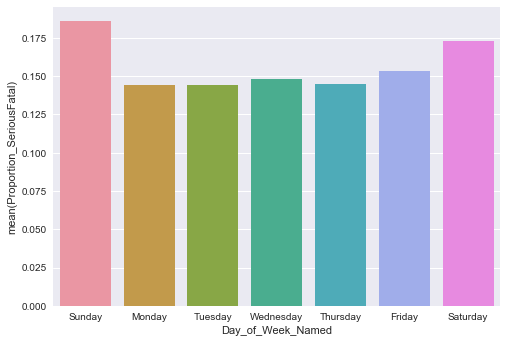

In [24]:
sns.barplot(x='Day_of_Week_Named', y='Proportion_SeriousFatal', data=gb_accidents,
           order=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])

## Light Conditions Investigation

In [25]:
acc['Light_Conditions'].value_counts()

1    102608
4     27551
6      7258
7      1920
5       719
Name: Light_Conditions, dtype: int64

In [26]:
pd.crosstab(index=acc['SeriousFatal'], columns=acc['Light_Conditions'], normalize='index')

Light_Conditions,1,4,5,6,7
SeriousFatal,,,,,
0,0.740047,0.195731,0.004789,0.045835,0.013598
1,0.692020,0.202087,0.007019,0.084557,0.014316


8.5% of all serious or fatal accidents occur when there is no lighting in darkness.

In [27]:
pd.crosstab(index=acc['SeriousFatal'], columns=acc['Light_Conditions'], normalize='columns')

Light_Conditions,1,4,5,6,7
SeriousFatal,,,,,
0,0.853959,0.841167,0.788595,0.747727,0.838542
1,0.146041,0.158833,0.211405,0.252273,0.161458


25% of all accidents that occur when there is no lighting in darkness are serious or fatal.

In [28]:
def named_light_conditions(x):
    if x==1:
        return 'Light'
    elif x==4:
        return 'Darkness with Lights Lit'
    elif x==5 or x==6:
        return 'Darkness with Lights Unlit / No Light'
    elif x==7:
        return 'Darkness with Lighting Unknown'
    else:
        return 'Missing'

acc['Light_Conditions_Named'] = acc['Light_Conditions'].apply(named_light_conditions)
df['Light_Conditions_Named'] = df['Light_Conditions'].apply(named_light_conditions)

In [29]:
acc[['Light_Conditions', 'Light_Conditions_Named']].head()

,Light_Conditions,Light_Conditions_Named
0,4,Darkness with Lights Lit
1,1,Light
2,4,Darkness with Lights Lit
3,1,Light
4,1,Light


In [30]:
grpby_light = acc[['Accident_Index', 'SeriousFatal', 'Light_Conditions_Named']].groupby('Light_Conditions_Named').aggregate({'Accident_Index':pd.Series.count, 'SeriousFatal':np.sum})
grpby_light['Proportion_Serious_or_Fatal'] = grpby_light['SeriousFatal'] / grpby_light['Accident_Index']
grpby_light.reset_index(inplace=True)
grpby_light

,Light_Conditions_Named,SeriousFatal,Accident_Index,Proportion_Serious_or_Fatal
0,Darkness with Lighting Unknown,310,1920,0.161458
1,Darkness with Lights Lit,4376,27551,0.158833
2,Darkness with Lights Unlit / No Light,1983,7977,0.248590
3,Light,14985,102608,0.146041


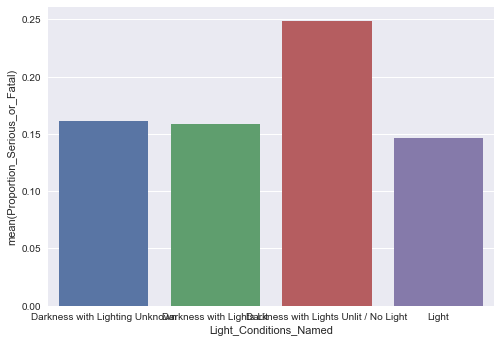

In [31]:
sns.barplot(data=grpby_light, x='Light_Conditions_Named', y='Proportion_Serious_or_Fatal')

Accidents are more likely to be serious or fatal if they are in darkness with no light compared with other lighting conditions.

## Propulsion

In [32]:
df[['Accident_Index', 'SeriousFatal', 'Propulsion_Code']].groupby('Propulsion_Code').aggregate({'Accident_Index':pd.Series.nunique, 'SeriousFatal':np.sum})

,SeriousFatal,Accident_Index
Propulsion_Code,,
-1,12164,57989
1,18338,82994
2,12142,63472
3,17,120
4,4,3
5,9,34
6,5,53
7,18,169
8,171,1921


Perhaps there are too few examples of each to really do much with this - also lots of missing data.

## Sex of Driver

In [33]:
grpby_sex = df[['Accident_Index', 'SeriousFatal', 'Sex_of_Driver']].groupby('Sex_of_Driver').aggregate({'Accident_Index':pd.Series.nunique, 'SeriousFatal':np.sum})
grpby_sex['Proportion_Serious_or_Fatal'] = grpby_sex['SeriousFatal'] / grpby_sex['Accident_Index']
grpby_sex

,SeriousFatal,Accident_Index,Proportion_Serious_or_Fatal
Sex_of_Driver,,,
-1,2,19,0.105263
1,31087,115539,0.269061
2,9623,60507,0.159039
3,2163,15150,0.142772


Males have nearly twice as many accidents as women. Since we would expect road usage to be roughly similar across the sexes, we can say that males are twice as likely to have accidents.

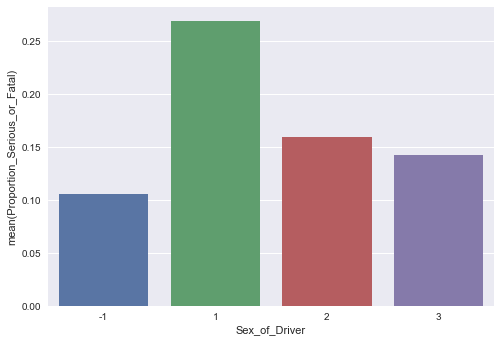

In [34]:
grpby_sex.reset_index(inplace=True)
sns.barplot(data=grpby_sex, x='Sex_of_Driver', y='Proportion_Serious_or_Fatal')

Males' accidents are far more likely to be serious or fatal.

In [35]:
univariate_proportion(df, 'Age_Band_of_Driver')

,SeriousFatal,Accident_Index,Proportion_Serious_or_Fatal
Age_Band_of_Driver,,,
-1,3172,27261,0.116357
1,7,67,0.104478
2,64,434,0.147465
3,268,1511,0.177366
4,3664,17672,0.207334
5,5004,27368,0.182841
6,8180,47116,0.173614
7,6930,39946,0.173484
8,7114,36746,0.193599


## Bivariate Analysis

In [36]:
def bivariate_proportion(data, field_name1, field_name2):
    grpby = data[['Accident_Index', 'SeriousFatal', field_name1, field_name2]].groupby([field_name1, field_name2]).aggregate({'Accident_Index':pd.Series.nunique, 'SeriousFatal':np.sum})
    grpby['Proportion_Serious_or_Fatal'] = grpby['SeriousFatal'] / grpby['Accident_Index']
    return grpby

In [37]:
grpby = bivariate_proportion(df, 'Sex_of_Driver', 'Age_Band_of_Driver')
#grpby = grpby[grpby['Proportion_Serious_or_Fatal']>0.2]
grpby.loc[1:2, :]

SeriousFatal  Accident_Index  \
Sex_of_Driver Age_Band_of_Driver                                 
1             -1                           937           10842   
               1                             7              52   
               2                            47             340   
               3                           244            1347   
               4                          2973           12898   
               5                          3913           18890   
               6                          6112           33255   
               7                          5117           28071   
               8                          5370           26319   
               9                          3361           15181   
               10                         1728            7621   
               11                         1278            4639   
2             -1                           238            2944   
               1                             0              13   
               2                            17              96   
               3                            23             165   
               4                           679            4973   
               5                          1070            9056   
               6                          2007           15980   
               7                          1780           13452   
               8                          1724           11755   
               9                           993            6097   
               10                          613            3322   
               11                          479            2017   

                                  Proportion_Serious_or_Fatal  
Sex_of_Driver Age_Band_of_Driver                               
1             -1                                     0.086423  
               1                                     0.134615  
               2                                     0.138235  
               3                                     0.181143  
               4                                     0.230501  
               5                                     0.207147  
               6                                     0.183792  
               7                                     0.182288  
               8                                     0.204035  
               9                                     0.221395  
               10                                    0.226742  
               11                                    0.275490  
2             -1                                     0.080842  
               1                                     0.000000  
               2                                     0.177083  
               3                                     0.139394  
               4                                     0.136537  
               5                                     0.118154  
               6                                     0.125594  
               7                                     0.132322  
               8                                     0.146661  
               9                                     0.162867  
               10                                    0.184527  
               11                                    0.237481

C:\Users\IBM_ADMIN\Anaconda2\lib\site-packages\matplotlib\transforms.py:661: RuntimeWarning: invalid value encountered in absolute
  inside = ((abs(dx0 + dx1) + abs(dy0 + dy1)) == 0)


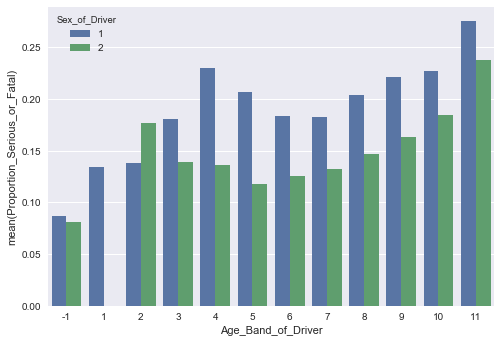

In [38]:
sns.barplot(data=grpby.loc[1:2, :].reset_index(), x='Age_Band_of_Driver', y='Proportion_Serious_or_Fatal', 
            hue='Sex_of_Driver')

In [39]:
grpby_veh_light = df[['Accident_Index', 'SeriousFatal', 'Vehicle_Type_Grouped', 'Light_Conditions_Named']].groupby(['Vehicle_Type_Grouped', 'Light_Conditions_Named']).aggregate({'Accident_Index':pd.Series.nunique, 'SeriousFatal':np.sum})
grpby_veh_light['Proportion_Serious_or_Fatal'] = grpby_veh_light['SeriousFatal'] / grpby_veh_light['Accident_Index']
grpby_veh_light = grpby_veh_light[grpby_veh_light['Accident_Index']>50]
grpby_veh_light[grpby_veh_light['Proportion_Serious_or_Fatal']>0.3]

SeriousFatal  \
Vehicle_Type_Grouped Light_Conditions_Named                                
Bus/Coach            Darkness with Lights Unlit / No Light            38   
Car                  Darkness with Lights Unlit / No Light          3209   
Minibus              Darkness with Lights Lit                         32   
                     Light                                           114   
Motorcycle           Darkness with Lights Unlit / No Light           294   
Other                Darkness with Lights Unlit / No Light            24   
Pedal Cycle          Darkness with Lights Unlit / No Light           128   
Van/HGV              Darkness with Lights Unlit / No Light           405   

                                                            Accident_Index  \
Vehicle_Type_Grouped Light_Conditions_Named                                  
Bus/Coach            Darkness with Lights Unlit / No Light              63   
Car                  Darkness with Lights Unlit / No Light            7151   
Minibus              Darkness with Lights Lit                           80   
                     Light                                             377   
Motorcycle           Darkness with Lights Unlit / No Light             625   
Other                Darkness with Lights Unlit / No Light              60   
Pedal Cycle          Darkness with Lights Unlit / No Light             321   
Van/HGV              Darkness with Lights Unlit / No Light            1146   

                                                            Proportion_Serious_or_Fatal  
Vehicle_Type_Grouped Light_Conditions_Named                                              
Bus/Coach            Darkness with Lights Unlit / No Light                     0.603175  
Car                  Darkness with Lights Unlit / No Light                     0.448748  
Minibus              Darkness with Lights Lit                                  0.400000  
                     Light                                                     0.302387  
Motorcycle           Darkness with Lights Unlit / No Light                     0.470400  
Other                Darkness with Lights Unlit / No Light                     0.400000  
Pedal Cycle          Darkness with Lights Unlit / No Light                     0.398754  
Van/HGV              Darkness with Lights Unlit / No Light                     0.353403

Since this is breaking it down to a 'player' level (ie vehicle or person), the probabilities seem inconsistent with the lighting conditions EDA above.

# Analyse just the Greater London Accidents

In [40]:
acc_lon.shape

(28889, 34)

In London, we have data for 28,889 accidents...

In [41]:
df_lon.shape

(56157, 70)

...involving 56,157 vehicles and people.

In [42]:
acc_lon['SeriousFatal'].mean()

0.0881650455190557

Interestingly, only 8.8% of accidents in Greater London are serious or fatal, compared with 15.4% for the UK as a whole.

In [44]:
univariate_proportion(acc_lon, 'Day_of_Week')

,SeriousFatal,Accident_Index,Proportion_Serious_or_Fatal
Day_of_Week,,,
1,289,3111,0.092896
2,351,4082,0.085987
3,362,4451,0.081330
4,381,4446,0.085695
5,404,4571,0.088383
6,419,4560,0.091886
7,341,3668,0.092966


In [46]:
univariate_proportion(df_lon, 'Sex_of_Driver')

,SeriousFatal,Accident_Index,Proportion_Serious_or_Fatal
Sex_of_Driver,,,
1,3490,25152,0.138756
2,799,10078,0.079282
3,293,2875,0.101913


In [47]:
univariate_proportion(df_lon, 'Age_Band_of_Driver')

,SeriousFatal,Accident_Index,Proportion_Serious_or_Fatal
Age_Band_of_Driver,,,
-1,711,8751,0.081248
1,2,10,0.200000
2,1,39,0.025641
3,21,174,0.120690
4,282,2363,0.119340
5,463,5172,0.089520
6,991,10610,0.093402
7,816,8709,0.093696
8,739,7191,0.102767


In [48]:
bivariate_proportion(df_lon, 'Sex_of_Driver', 'Age_Band_of_Driver')

SeriousFatal  Accident_Index  \
Sex_of_Driver Age_Band_of_Driver                                 
1             -1                           353            5048   
               1                             2               8   
               2                             1              28   
               3                            19             157   
               4                           237            1890   
               5                           378            3884   
               6                           809            8212   
               7                           654            6732   
               8                           600            5580   
               9                           262            2510   
               10                          110             903   
               11                           65             464   
2             -1                            70            1112   
               1                             0               2   
               2                             0              11   
               3                             2              17   
               4                            44             493   
               5                            84            1372   
               6                           182            2871   
               7                           160            2276   
               8                           138            1812   
               9                            66             796   
               10                           31             386   
               11                           22             188   
3             -1                           288            2836   
               4                             1               1   
               5                             1               6   
               6                             0              10   
               7                             2               5   
               8                             1              12   
               9                             0               5   
               11                            0               1   

                                  Proportion_Serious_or_Fatal  
Sex_of_Driver Age_Band_of_Driver                               
1             -1                                     0.069929  
               1                                     0.250000  
               2                                     0.035714  
               3                                     0.121019  
               4                                     0.125397  
               5                                     0.097322  
               6                                     0.098514  
               7                                     0.097148  
               8                                     0.107527  
               9                                     0.104382  
               10                                    0.121816  
               11                                    0.140086  
2             -1                                     0.062950  
               1                                     0.000000  
               2                                     0.000000  
               3                                     0.117647  
               4                                     0.089249  
               5                                     0.061224  
               6                                     0.063393  
               7                                     0.070299  
               8                                     0.076159  
               9                                     0.082915  
               10                                    0.080311  
               11                                    0.117021  
3             -1                                     0.101551  
               4                                     1.000000

In [49]:
df_lon.columns

Index([u'Accident_Index', u'Location_Easting_OSGR', u'Location_Northing_OSGR',
       u'Longitude', u'Latitude', u'Police_Force', u'Accident_Severity',
       u'Number_of_Vehicles', u'Number_of_Casualties', u'Date', u'Day_of_Week',
       u'Time', u'Local_Authority_(District)', u'Local_Authority_(Highway)',
       u'1st_Road_Class', u'1st_Road_Number', u'Road_Type', u'Speed_limit',
       u'Junction_Detail', u'Junction_Control', u'2nd_Road_Class',
       u'2nd_Road_Number', u'Pedestrian_Crossing-Human_Control',
       u'Pedestrian_Crossing-Physical_Facilities', u'Light_Conditions',
       u'Weather_Conditions', u'Road_Surface_Conditions',
       u'Special_Conditions_at_Site', u'Carriageway_Hazards',
       u'Urban_or_Rural_Area', u'Did_Police_Officer_Attend_Scene_of_Accident',
       u'LSOA_of_Accident_Location', u'Vehicle_Reference',
       u'Casualty_Reference', u'Casualty_Class', u'Sex_of_Casualty',
       u'Age_of_Casualty', u'Age_Band_of_Casualty', u'Casualty_Severity',
       u'P

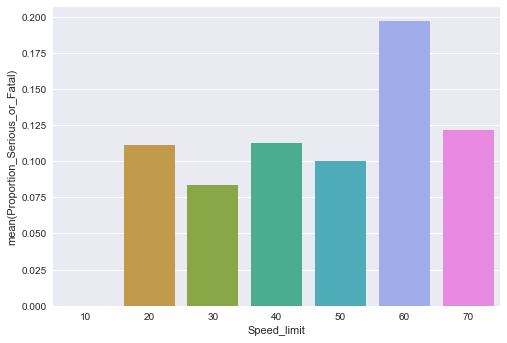

In [50]:
produce_proportion_chart(univariate_proportion(acc_lon, 'Speed_limit'), 'Speed_limit')

In [51]:
univariate_proportion(acc_lon, 'Road_Surface_Conditions')

,SeriousFatal,Accident_Index,Proportion_Serious_or_Fatal
Road_Surface_Conditions,,,
-1,0,19,0.000000
1,2124,24057,0.088290
2,407,4706,0.086485
3,1,11,0.090909
4,13,83,0.156627
5,2,13,0.153846


4 = Frost or ice <br/>
5 = Flood over 3cm deep

In [52]:
univariate_proportion(df_lon, 'Journey_Purpose_of_Driver')

,SeriousFatal,Accident_Index,Proportion_Serious_or_Fatal
Journey_Purpose_of_Driver,,,
1,750,7062,0.106202
2,398,3405,0.116887
3,25,342,0.073099
4,3,122,0.024590
5,7,43,0.162791
6,3399,23962,0.141850


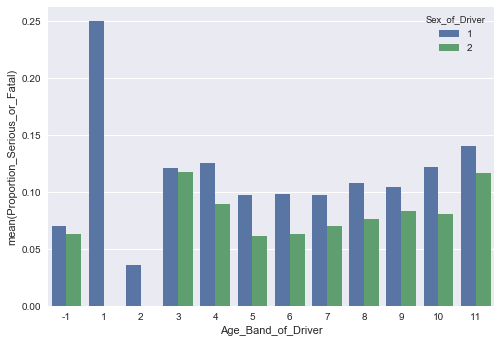

In [53]:
temp = bivariate_proportion(df_lon, 'Sex_of_Driver', 'Age_Band_of_Driver').loc[1:2, :]
temp.reset_index(inplace=True)
sns.barplot(data=temp, x='Age_Band_of_Driver', y='Proportion_Serious_or_Fatal', hue='Sex_of_Driver')

In [54]:
acc.columns

Index([u'Accident_Index', u'Location_Easting_OSGR', u'Location_Northing_OSGR',
       u'Longitude', u'Latitude', u'Police_Force', u'Accident_Severity',
       u'Number_of_Vehicles', u'Number_of_Casualties', u'Date', u'Day_of_Week',
       u'Time', u'Local_Authority_(District)', u'Local_Authority_(Highway)',
       u'1st_Road_Class', u'1st_Road_Number', u'Road_Type', u'Speed_limit',
       u'Junction_Detail', u'Junction_Control', u'2nd_Road_Class',
       u'2nd_Road_Number', u'Pedestrian_Crossing-Human_Control',
       u'Pedestrian_Crossing-Physical_Facilities', u'Light_Conditions',
       u'Weather_Conditions', u'Road_Surface_Conditions',
       u'Special_Conditions_at_Site', u'Carriageway_Hazards',
       u'Urban_or_Rural_Area', u'Did_Police_Officer_Attend_Scene_of_Accident',
       u'LSOA_of_Accident_Location', u'SeriousFatal', u'IsGreaterLondon',
       u'Light_Conditions_Named'],
      dtype='object')

In [55]:
acc.iloc[:,:15].head()

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class
0,201501BS70001,525130.0,180050.0,-0.198465,51.505538,1,3,1,1,12/01/2015,2,18:45,12,E09000020,5
1,201501BS70002,526530.0,178560.0,-0.178838,51.491836,1,3,1,1,12/01/2015,2,07:50,12,E09000020,6
2,201501BS70004,524610.0,181080.0,-0.205590,51.514910,1,3,1,1,12/01/2015,2,18:08,12,E09000020,4
3,201501BS70005,524420.0,181080.0,-0.208327,51.514952,1,3,1,1,13/01/2015,3,07:40,12,E09000020,4
4,201501BS70008,524630.0,179040.0,-0.206022,51.496572,1,2,2,1,09/01/2015,6,07:30,12,E09000020,3


In [56]:
from sklearn.cross_validation import train_test_split

C:\Users\IBM_ADMIN\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [103]:
acc_X = acc[['Number_of_Casualties',
             #'Road_Type',
             #'Speed_limit',
             #'Light_Conditions',
             #'Weather_Conditions',
             #'Road_Surface_Conditions',
             'Did_Police_Officer_Attend_Scene_of_Accident']]
acc_y = acc['SeriousFatal']

In [104]:
X1, X2, y1, y2 = train_test_split(acc_X, acc_y, random_state=0)

In [105]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
y_model1 = model.fit(X1, y1).predict(X2)
y_model2 = model.fit(X2, y2).predict(X1)

In [106]:
from sklearn.metrics import accuracy_score

In [107]:
print accuracy_score(y2, y_model1)
print accuracy_score(y1, y_model2)

0.833380933341
0.836170293787


In [109]:
from sklearn.metrics import confusion_matrix

In [110]:
confusion_matrix(y2, y_model1)

array([[28935,   604],
       [ 5230,   245]])